In [1]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt

In [2]:
mech = 'FeSiO2_NOMC.yaml'

In [16]:
# import the model for gas-Fe Interface and adjacent gas phase
Fe_surf = ct.Interface(mech, 'Fe_surf')
gas = Fe_surf.adjacent['gas']

In [104]:
gas = ct.Solution('gri30_cs.yaml')
desired_elements = {'C','H'}
desired_species = ['CH3', 'CH4', 'C2H2', 'C2H4','C2H6', 'C3H8','H2']

print(gas.net_rates_of_progress)

[ 0.00000000e+00 -3.47273377e-66  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


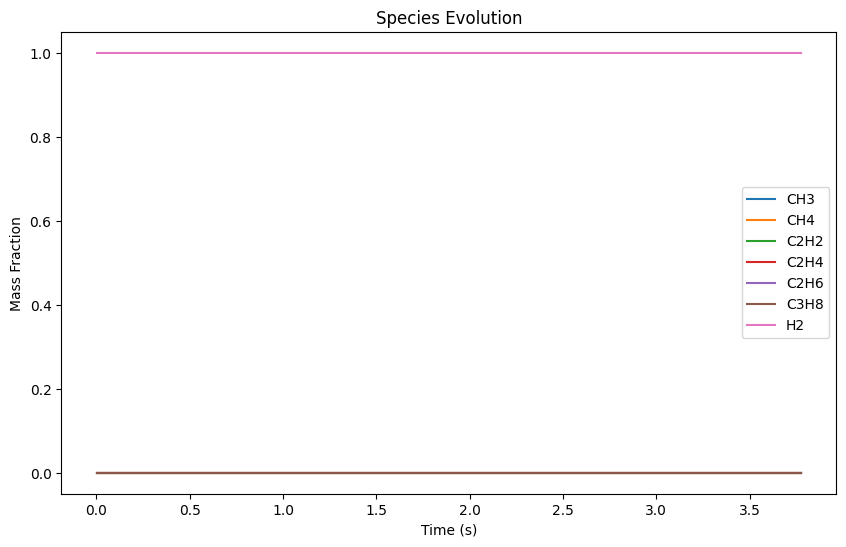

In [105]:
gas.TPX = 2000, ct.one_atm, {'CH4':1}

r = ct.IdealGasConstPressureReactor(g,energy='off')
sim = ct.ReactorNet([r])

time = 0.0
states = ct.SolutionArray(gas, extra=['t'])

while time < 1:
    time = sim.step()
    states.append(r.thermo.state, t=time)

# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for sp in desired_species:
    plt.plot(states.t, states(sp).Y, label=sp)
plt.xlabel('Time (s)')
plt.ylabel('Mass Fraction')
plt.legend()
plt.title('Species Evolution')
plt.show()